# Exp7: Sentence Embeddings
This file tests neural networks trained on sentence embeddings to predict the presence of grammatical constructions in them.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import random
from tqdm import tqdm
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import config

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)
random.seed(config.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.empty_cache()

In [22]:
print(torch.cuda.memory_summary(device=device))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2533 MiB |   3331 MiB |   6453 GiB |   6451 GiB |
|       from large pool |   2530 MiB |   3310 MiB |   6195 GiB |   6193 GiB |
|       from small pool |      2 MiB |     22 MiB |    258 GiB |    258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2533 MiB |   3331 MiB |   6453 GiB |   6451 GiB |
|       from large pool |   2530 MiB |   3310 MiB |   6195 GiB |

Load dataset

In [4]:
df = pd.read_json('../dat/egpaugmented_54x100.json')

Load and test embeddings model

In [23]:
# Extracting one construct with its examples
row = df.iloc[1]
print(row['Can-do statement'])
print(row['Example'])
print("\n")
for element in row['augmented_examples'][:10]:
    print(element)
print("\n")
for element in row['augmented_negative_examples'][:10]:
    print(element)

class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        #return torch.tensor(self.embeddings[idx], device=device), torch.tensor(self.labels[idx], device=device)
        encoding = self.tokenizer.encode_plus(
            self.sentences[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
def get_dataset(row, tokenizer, max_len, random_negatives=True):
    # assemble dataset for one construction
    # 50% positive examples
    sentences = list(row['augmented_examples'])
    labels = [1] * len(row['augmented_examples'])

    if random_negatives:
        ratio = 0.5
        num_rands = int(len(sentences) * ratio)
        num_augs = int(len(sentences) * (1-ratio))

        # 25% random negative examples (positive from other constructions)
        neg_examples = [example for sublist in df.loc[df['#'] != row['#'], 'augmented_examples'].to_list() for example in sublist]
        random.shuffle(neg_examples)
        sentences += neg_examples[:num_rands]
        labels += [0] * len(neg_examples[:num_rands])

        # 25% augmented negative examples
        aug_neg_examples = row['augmented_negative_examples']
        random.shuffle(aug_neg_examples)
        sentences += aug_neg_examples[:num_augs]
        labels += [0] * len(aug_neg_examples[:num_augs])
    else:
        sentences += row['augmented_negative_examples']
        labels = [0] * len(row['augmented_negative_examples'])

    #embeddings = embeddings_model.encode(sentences)
    return SentenceDataset(sentences, labels, tokenizer, max_len)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128  # Max length for BERT

# Get dataset for a specific row
dataset = get_dataset(row, tokenizer, max_len)

Can use 'very' to modify common gradable adjectives.
My home is very nice. 

My teacher is very good.


The weather is very hot today.
His car is very fast.
The movie was very entertaining.
The food at that restaurant is very delicious.
The book is very interesting.
The music is very loud.
His dog is very friendly.
The exam was very difficult.
The party was very fun.
Her dress is very beautiful.


I am utterly exhausted after a long day at work.
The movie was incredibly entertaining.
The weather is incredibly hot.
This book is truly interesting.
The music is exceedingly loud.
The food is incredibly tasty.
His dog is incredibly playful.
The museum exhibit was utterly impressive.
The dog is extremely friendly.
The food is exceptionally delicious.


Create a data loader.

In [24]:
# Total size of the dataset
total_size = len(dataset)

# Specify the size of the training and validation sets
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Let's define our network, a simple two layer Feed Forward Neural Network with a sigmoidal activation function.

In [26]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/qb/work/meurers/mpb672/conda_envs/llm2/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 109483778
Trainable Parameters: 109483778


Now we can train the network with the sentence embeddings.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.03it/s]


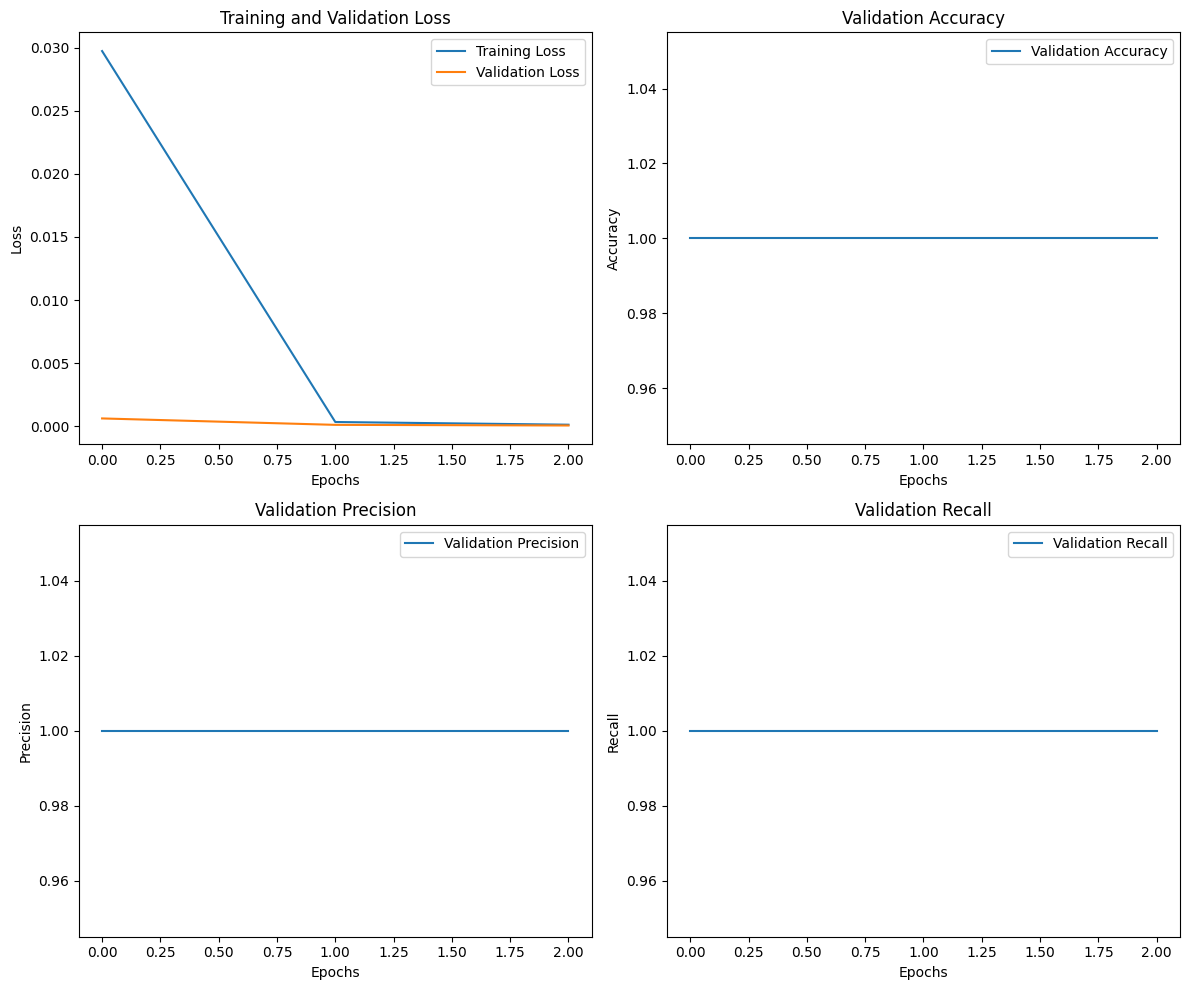

(BertForSequenceClassification(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): LayerN

In [33]:
# Loss and Optimizer
criterion = torch.nn.BCELoss()

def train(model, train_dataloader, val_dataloader, verbose=True, plots=True, n_epochs_stop = 10, lr=0.0001, num_epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr)

    # Lists to store loss and accuracy values
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training Loop
    for epoch in range(num_epochs):  # Number of epochs
        model.train()  # Set the model to training mode
        total_loss = 0
        train_steps = 0
        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            train_steps += 1
        
        avg_train_loss = total_loss / train_steps
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_steps = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # forward pass
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                val_steps += 1

                predicted = outputs.logits.argmax(dim=1)  # Assuming a binary classification

                # Accumulate all targets and predictions
                all_targets.extend(labels.tolist())
                all_predictions.extend(predicted.tolist())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        # Calculating validation metrics
        avg_val_loss = val_loss / val_steps
        val_losses.append(avg_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Calculate precision and recall
        precision = precision_score(all_targets, all_predictions)
        recall = recall_score(all_targets, all_predictions)
        val_precisions.append(precision)
        val_recalls.append(recall)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print(f'Early stopping at epoch {epoch+1}')
                break

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    # Plotting training and validation loss, accuracy, precision, and recall
    if plots:
        plt.figure(figsize=(12, 10))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(val_precisions, label='Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.title('Validation Precision')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(val_recalls, label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.title('Validation Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return model, val_accuracy, precision, recall

train(model, train_dataloader, val_dataloader, verbose=True)

Let's try cross validation to make sure that the validation is not influenced by the validation set sampling.

In [38]:
def CV_train(construction, k_folds = 3, batch_size=32, random_negatives=True):
    print(construction['Can-do statement'])
    dataset = get_dataset(row, tokenizer, max_len)

    accuracies = []
    precisions = []
    recalls = []

    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(list(range(len(dataset))))):
        print(f'FOLD {fold}')

        # Prepare data for fold
        trainloader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids))
        testloader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_ids))

        # Reinitialize model
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

        # Train model
        model, val_accuracy, precision, recall = train(model, trainloader, testloader, plots=True, verbose=True, num_epochs=1)

        # Store metrics
        accuracies.append(val_accuracy)
        precisions.append(precision)
        recalls.append(recall)

    return accuracies, precisions, recalls

results = []
for idx, construction in df.iterrows():
    accuracies, precisions, recalls = CV_train(construction)
    print(accuracies)
    results.append({'Construction': construction['Level'] + '-' + str(construction['#']), 
                    'Accuracies': accuracies, 
                    'Precisions': precisions, 
                    'Recalls': recalls})
results_df = pd.DataFrame(results)

Can form simple noun phrases with a limited range of determiners + singular and plural nouns. ► Nouns and noun phrases: functions
FOLD 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 9.77 GiB already allocated; 8.69 MiB free; 9.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
results_df.to_json('../dat/classification_results_54.json')

## Analyze results

In [45]:
results_df = pd.read_json('../dat/classification_results_54.json')

Add the type to the construction, again.

In [46]:
egp = pd.read_csv('../dat/egponline.csv')

results_df['Construction_ID'] = results_df['Construction'].apply(lambda x: x[3:]).astype("int64")
merged_df = results_df.merge(egp, left_on='Construction_ID', right_on='#', how='left')
results_df['type'] = merged_df['type']

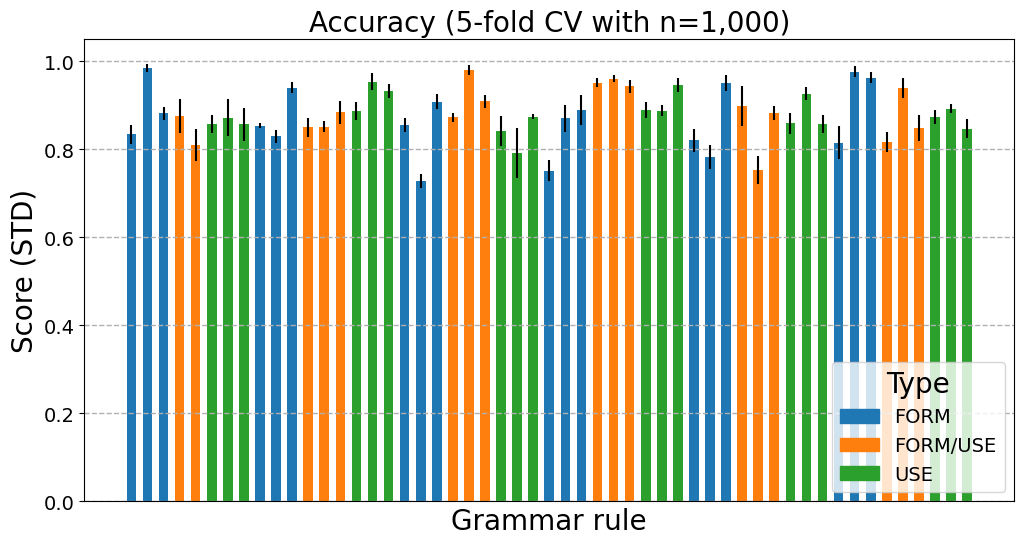

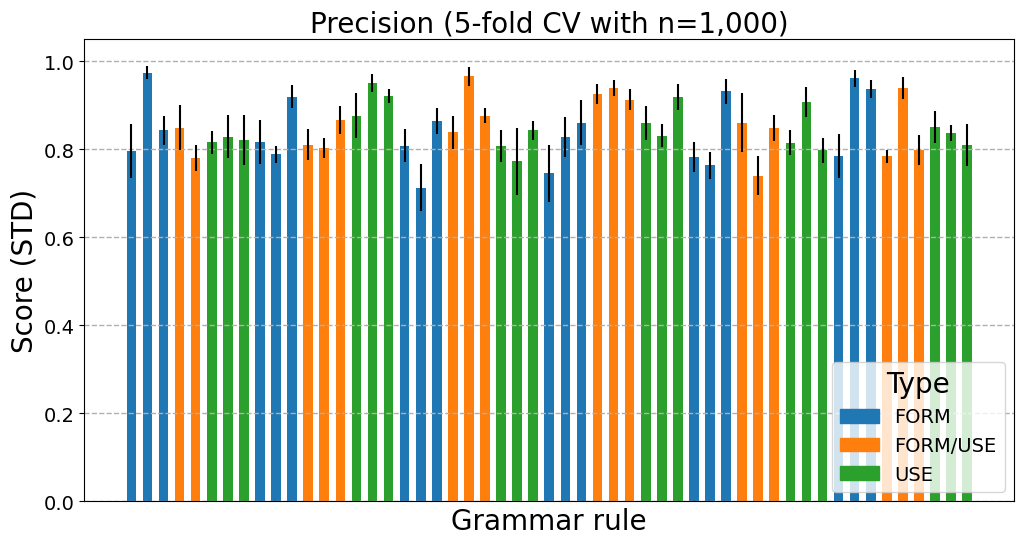

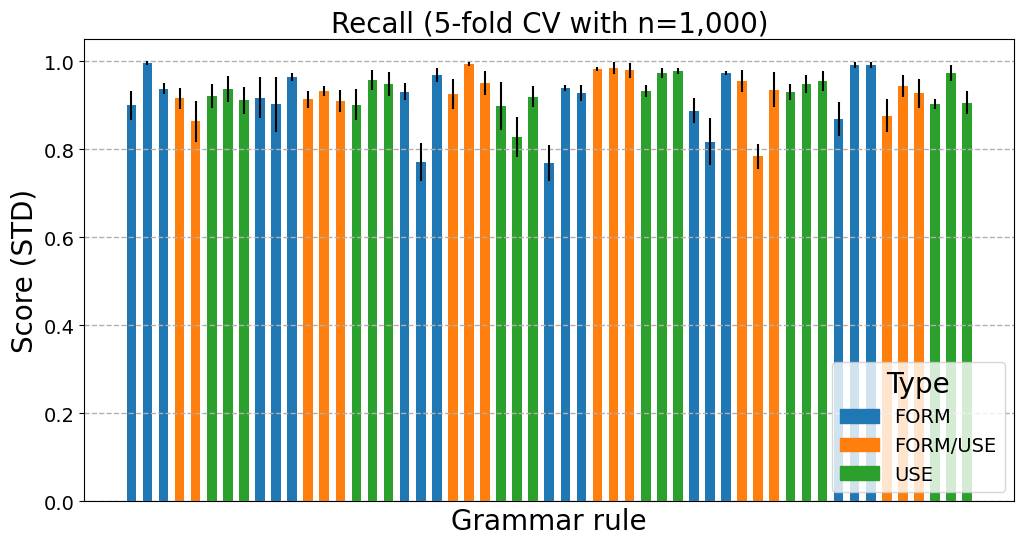

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches

# Update default font sizes
rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 14,
                 'ytick.labelsize': 14, 'legend.fontsize': 14})

def calculate_mean_std(values):
    return np.mean(values), np.std(values)

metrics = ['Accuracies', 'Precisions', 'Recalls']
for metric in metrics:
    results_df[[f'{metric} Mean', f'{metric} Std']] = results_df[metric].apply(calculate_mean_std).apply(pd.Series)

width = 0.6
x = np.arange(len(results_df))

categories = results_df['type'].unique()
colors = plt.cm.tab10(range(0, len(categories)))
color_map = dict(zip(categories, colors))

for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_ylim(0, 1.05)

    bar = ax.bar(x, results_df[f'{metric} Mean'], width, yerr=results_df[f'{metric} Std'], color=[color_map[t] for t in results_df['type']])

    ax.set_xlabel('Grammar rule')
    ax.set_ylabel('Score (STD)')
    ax.set_title(f'{"Accuracy" if "Acc" in metric else metric[:-1]} (5-fold CV with n=1,000)')
    ax.set_xticks([])

    legend_handles = [mpatches.Patch(color=color_map[cat], label=cat) for cat in categories]
    ax.legend(handles=legend_handles, loc="lower right", title="Type")

    plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1)

    plt.savefig(f'../doc/classification_{metric[:-1].lower()}.pdf', transparent=True, bbox_inches='tight')


Now let's train the models and save them to make them accessible:

In [12]:
batch_size=64
num_epochs=60
hidden_dim=32
random_negatives=True
lr=0.0001

for idx, construction in df.iterrows():
    print(construction['Can-do statement'])
    dataset = get_dataset(construction, random_negatives)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FeedforwardNN(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_steps = 0
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_steps += 1
    
    torch.save(model, f"../models/{construction['#']}.pth")

Can use nouns and noun phrases as complements of the verb 'be'. 
Can use prepositional phrases in the front position for focus.
Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-giving. 
Can use the past perfect continuous in a relative clause to give background information.  ► relative clauses
Can use 'anything' with post-modifiers to form complex noun phrases as subjects with a singular verb, to give focus. 
Can use an increasing range of adjectives before a noun to express intensity.
